# # Daily Extremes Timeseries from 2D Fields (25km IAF JRA55-do, ACCESS-OM3)

This notebook uses daily extreme values derived from 2D fields, using the [dev-MC_25km_jra_iaf configuration](https://github.com/ACCESS-NRI/access-om3-configs/tree/efc6d1f913b453898aa82fa40dbe133560c6bad2) of ACCESS-OM3.

In [1]:
#parameters

### USER EDIT start
esm_file='/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/2025.02.000/c1_25km_iaf_check-max-min-daily-only/perturb_1/MC_25km_jra_iaf/archive/experiment_datastore.json'
plotfolder='/g/data/tm70/ml0072/COMMON/git_repos/access-om3-paper-1/notebooks/mkfigs_output/'
dpi=300
### USER EDIT stop

import matplotlib as mpl
import os
%matplotlib inline
mpl.rcParams['figure.dpi']= dpi

os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/2025.02.000/c1_25km_iaf_check-max-min-daily-only/perturb_1/MC_25km_jra_iaf/archive/experiment_datastore.json
Plot folder path:  /g/data/tm70/ml0072/COMMON/git_repos/access-om3-paper-1/notebooks/mkfigs_output/


In [2]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cftime

In [3]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Load ACCESS-OM3 data from ESM datastore

In [4]:
#datastore_path = "/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/2025.02.000/c1_25km_iaf_check-max-min-daily-only/perturb_1/MC_25km_jra_iaf/archive/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [5]:
variables = ["tos_min", "tos_max", 
             "sos_min", "sos_max",
             "speed_min", "speed_max",
             "mlotst_min", "mlotst_max",
            ]
data = {
    v: datastore.search(variable=v, frequency="1day").to_dask(
        xarray_open_kwargs=dict(chunks={"time": -1}, decode_timedelta=True)
    )
    for v in variables
}

{'tos': {'min': 'tos_min', 'max': 'tos_max'}, 'sos': {'min': 'sos_min', 'max': 'sos_max'}, 'speed': {'min': 'speed_min', 'max': 'speed_max'}, 'mlotst': {'min': 'mlotst_min', 'max': 'mlotst_max'}}


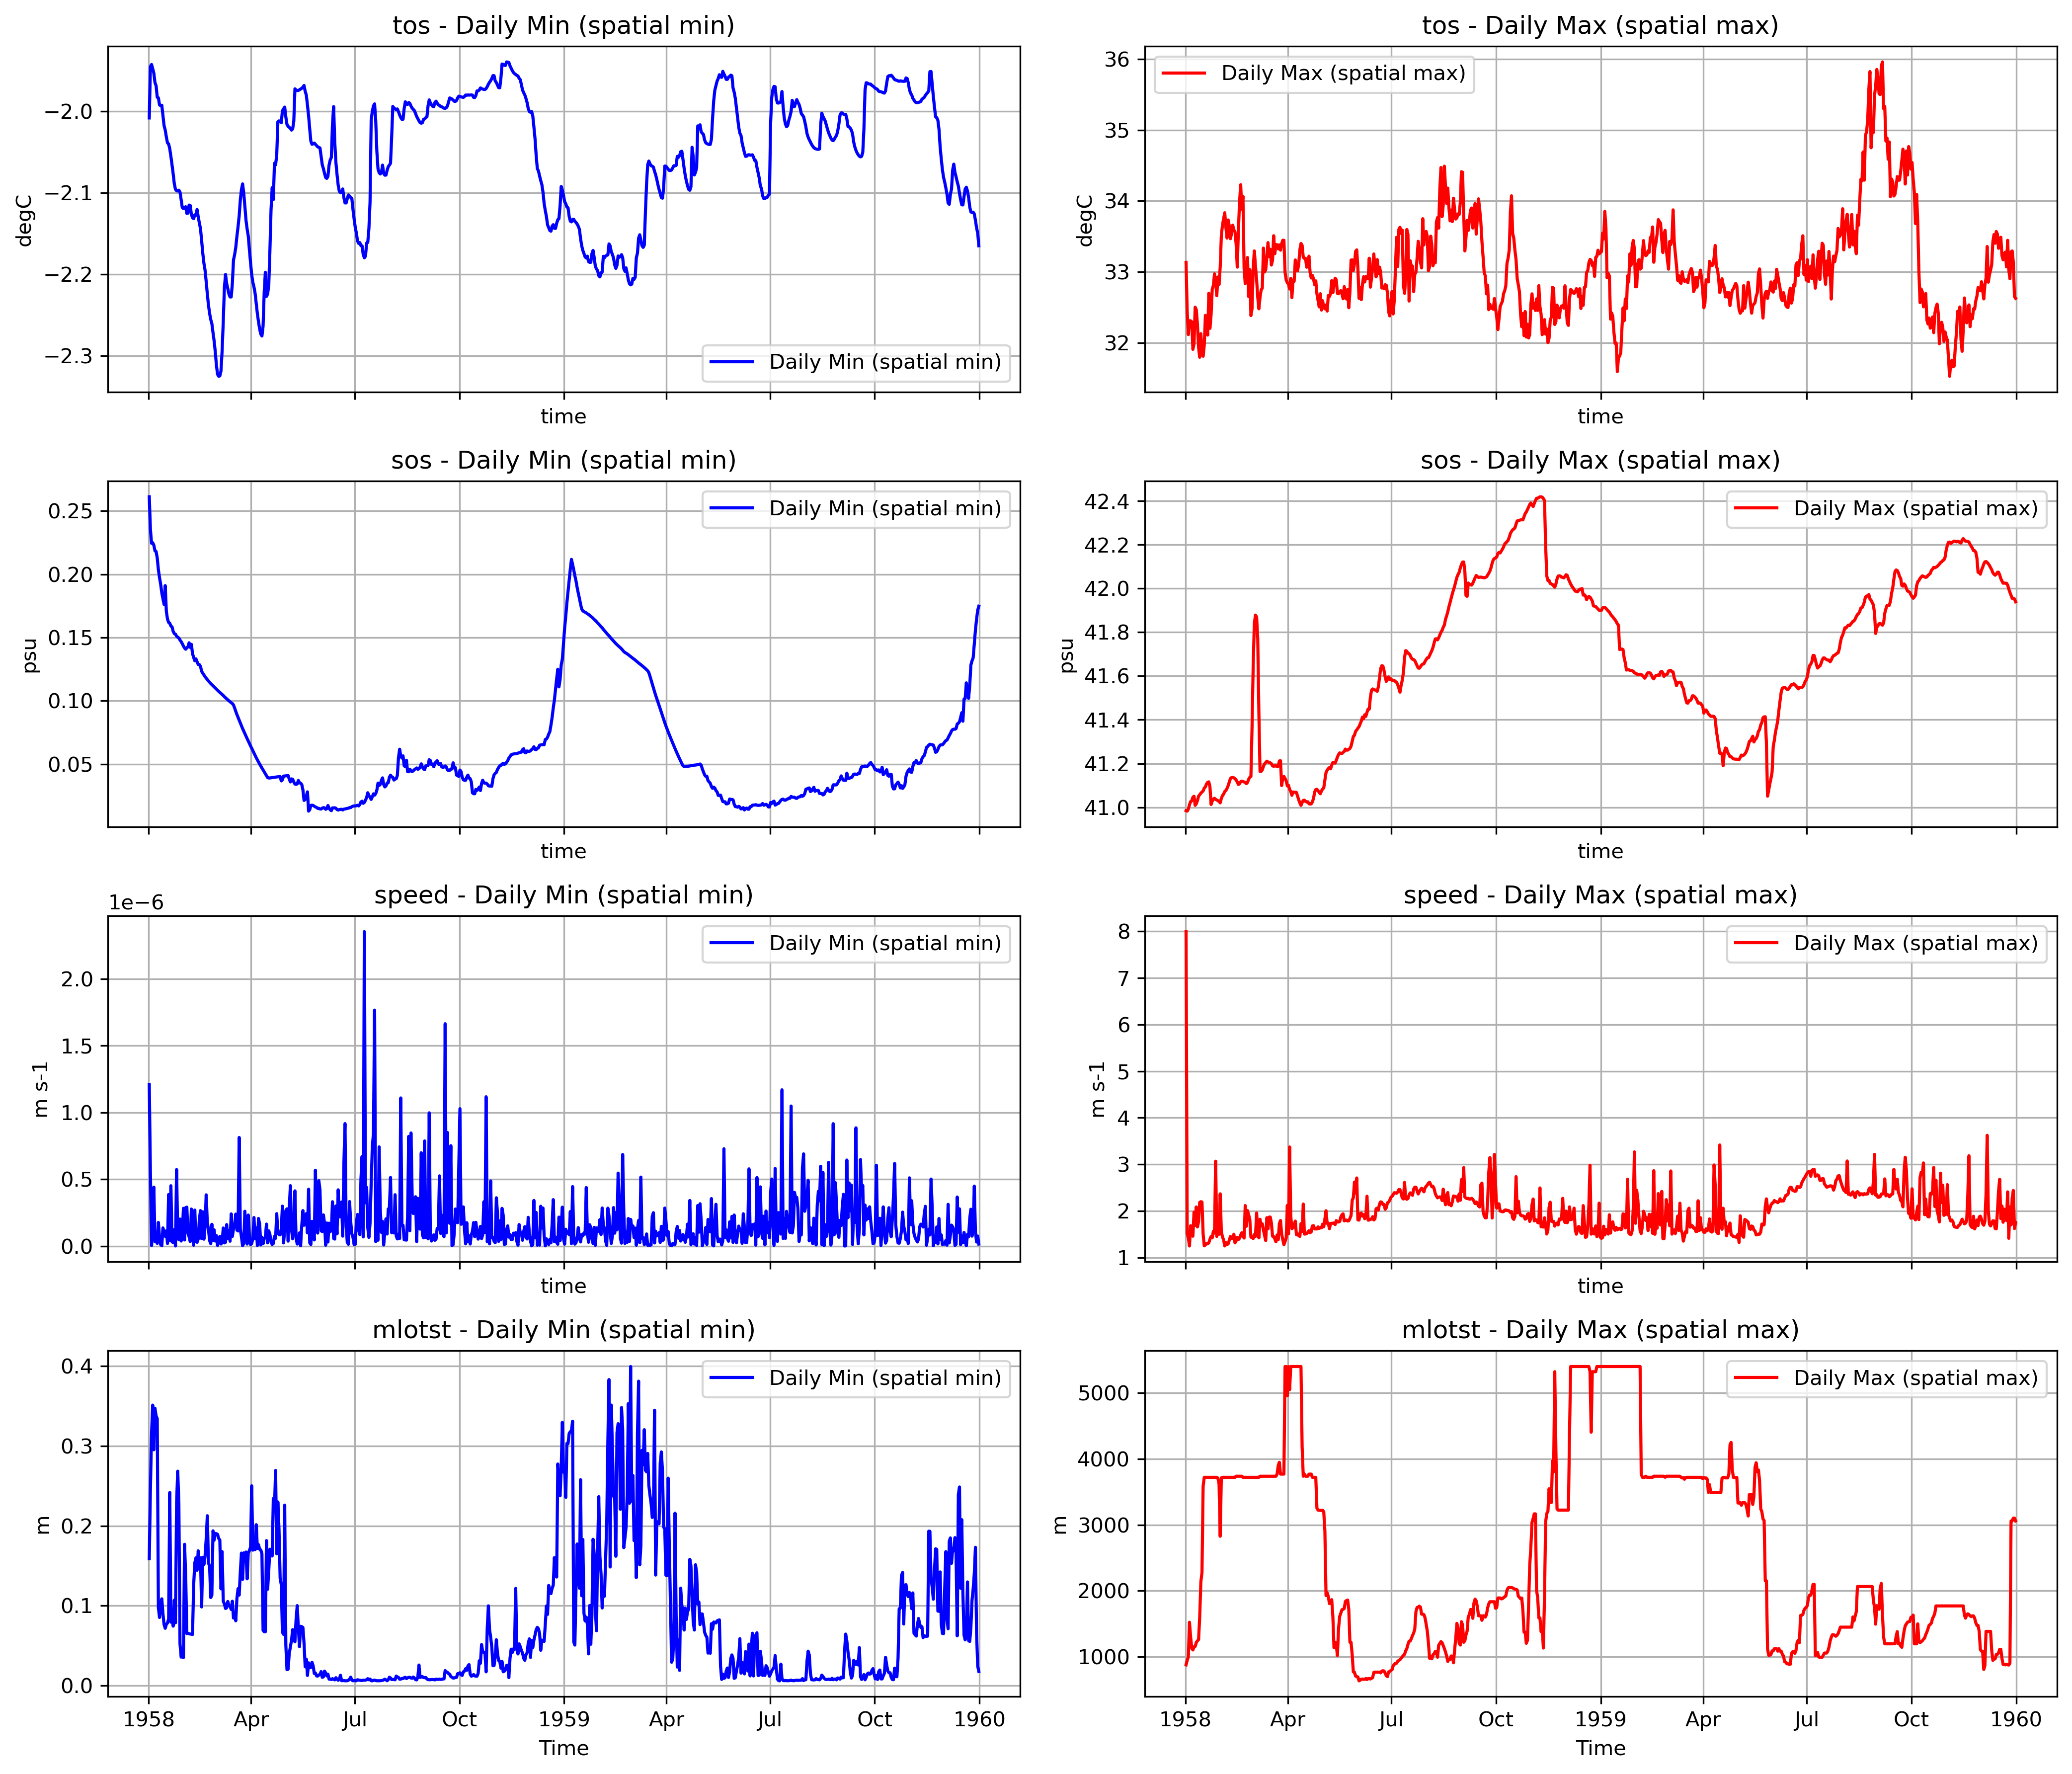

In [6]:
pairs = {}
for v in data:
    if v.endswith("_min"):
        pairs.setdefault(v[:-4], {})["min"] = v
    elif v.endswith("_max"):
        pairs.setdefault(v[:-4], {})["max"] = v

print(pairs)

fig, axes = plt.subplots(len(pairs), 2, figsize=(14, 3*len(pairs)), sharex=True)
if len(pairs) == 1:
    axes = axes[None, :]

for i, (base, pair) in enumerate(pairs.items()):
    if "min" not in pair or "max" not in pair:
        continue

    da_min = data[pair["min"]][pair["min"]]
    da_max = data[pair["max"]][pair["max"]]

    ts_min = da_min.min(dim=("yh", "xh"))
    ts_max = da_max.max(dim=("yh", "xh"))
    units  = da_min.attrs.get("units")

    ts_min.plot(ax=axes[i, 0], color="b", linewidth=1.5, label="Daily Min (spatial min)")
    axes[i, 0].set_title(f"{base} - Daily Min (spatial min)")
    axes[i, 0].set_ylabel(units); axes[i, 0].grid(True); axes[i, 0].legend()

    ts_max.plot(ax=axes[i, 1], color="r", linewidth=1.5, label="Daily Max (spatial max)")
    axes[i, 1].set_title(f"{base} - Daily Max (spatial max)")
    axes[i, 1].set_ylabel(units); axes[i, 1].grid(True); axes[i, 1].legend()

axes[-1, 0].set_xlabel("Time")
axes[-1, 1].set_xlabel("Time")
plt.tight_layout()
plt.savefig(f"{plotfolder}/timeseries_vars_minmax.png", dpi=150)
plt.show()

In [7]:
client.close()

2025-09-05 15:16:19,770 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/access-vis-0.4/lib/python3.11/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/access-vis-0.4/lib/python3.11/site-packages/distributed/worker.py", line 1267, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/access-vis-0.4/lib/python3.11/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/g/data